In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h2> Activation function for all nodes uses the following sigmoid function </h2>
<h1> $$ \frac{1}{(1 + e^{-\theta^\intercal X})} $$ </h1>

In [297]:
def sigmoid(layer_input):
    return 1 / (1 + np.exp(-(layer_input)))

In [409]:
def add_ones_row(layer_output):
    if (layer_output.ndim == 1):
        layer_output = layer_output.reshape(1,len(layer_output)) # single dimension will lead to error
    ones = np.ones((1,layer_output.shape[1]), dtype = float) # adding in 1s for bias weight
    layer_output = np.append(ones, layer_output, axis=0)
    return layer_output

In [410]:
def forward_propagation(weights, X):
    n = len(weights) # number of layers - 1, also number of iterations for foward propagation
    layer_outputs = []
    layer_output = X.transpose() # makes a copy as we need to add 1 to it to form first layer output
    for i in range(n):
        layer_output = add_ones_row(layer_output) # adding column of 1 so bias term for each layer is included
        layer_outputs.append(layer_output) # important to include the 1 in as it is used for calculation in back propagation
        layer_weight = weights[i]
        layer_input = np.matmul(layer_weight, layer_output) # calculating z, input to next layer
        layer_output = sigmoid(layer_input) # calculating z, output of next layer
    layer_outputs.append(layer_output)
    return layer_outputs

In [357]:
def calculate_cost(final_output, weights, y, lbd):
    m = final_output.shape[1]
    sum_squared_weights = sum(list(map(lambda x: (x**2).sum(),weights))) # sum of squared weights
    regularization_cost = (lbd/(2*m))*(sum_squared_weights)
    cost = (1/m)*(-y*np.log(final_output)-(1-y)*np.log(1-final_output)).sum() + regularization_cost
    return cost

In [358]:
def back_propagation(weights, layer_outputs, y):
    n = len(weights) # number of layers - 1, also number of iterations for foward propagation
    gradients = []
    layer_error = None;
    for i in range(n,0,-1): # from n to 1 inclusive
        if (i == n):
            layer_error = layer_outputs[i] - y # final layer output - y
        else:    
            layer_error = np.matmul(weights[i].transpose(),layer_error)*layer_outputs[i]*(1-layer_outputs[i]) # vectorized implementation for layer error calculation
            layer_error =  np.delete(layer_error, (0), axis=0) # remove first row which correspond to bias node
        if (layer_error.ndim == 1):
            layer_error = layer_error.reshape(1,len(layer_error)) # reshape from 1d to 2d so no error occurs
        grad = np.matmul(layer_error,layer_outputs[i-1].transpose())
        gradients.insert(0,grad)
    return gradients
        

In [420]:
def neural_network(X, y, network_structure, iterations, alpha, lbd):
    weights=[]
    train_costs = []
    m = X.shape[0]
    for i in range(len(network_structure)-1): # intializing weights
        layer_weights = np.random.rand(network_structure[i+1],network_structure[i]+1) # +1 for bias
        if (layer_weights.ndim == 1):
            layer_weights = layer_weights.reshape(1,len(layer_weights))
        weights.append(layer_weights)
    print(weights)    
    for i in range(iterations):
        layer_outputs = forward_propagation(weights, X) # forward propagation to calculate output of nodes at each layer
        iter_cost = calculate_cost(layer_outputs[-1], weights, y, lbd)
        train_costs.append(iter_cost)
        gradients = back_propagation(weights, layer_outputs, y) # back progagation to calculate gradient of nodes at each layer
        for j in range(len(weights)):
            weights[j] -= (alpha/m)*(gradients[j]) + (lbd/m)*(weights[j])    
    x_graph = np.arange(0,iterations,1);    
    plt.plot(x_graph,train_costs, label='train') 
    plt.legend()
    return weights

In [360]:
def normalize(X, mean, std):
    return (X-mean) / std

In [634]:
def prediction(X, weights, threshold):
    layer_outputs = forward_propagation(weights, X)
    pred_result = layer_outputs[-1]
    print(pred_result)
    pred_result = (pred_result>=threshold).astype(int) # those above threshold = 1, 0 otherwise
    return pred_result

In [362]:
def gradient_checking(X, y, network_structure, lbd):
    grads_test = []
    epsilon = 0.0001
    weights = []
    m=X.shape[0]
    
    for i in range(len(network_structure)-1): # intializing weights
        layer_weights = np.random.rand(network_structure[i+1],network_structure[i]+1) # +1 for bias
        if (layer_weights.ndim == 1):
            layer_weights = layer_weights.reshape(1,len(layer_weights))
        weights.append(layer_weights)
        
    for layer_weight in weights:
        rows = layer_weight.shape[0]
        cols = layer_weight.shape[1]
        grad = np.zeros((rows ,cols))
        for j in range(rows):
            for k in range(cols):
                layer_weight[j][k] += epsilon
                layer_output_1 = forward_propagation(weights, X)

                cost_1 = calculate_cost(layer_output_1[-1], weights, y, lbd)
                layer_weight[j][k] -= 2*epsilon
                layer_output_2 = forward_propagation(weights, X)
                cost_2 = calculate_cost(layer_output_2[-1], weights, y, lbd)
                layer_weight[j][k] += epsilon
                
                grad[j][k] = (cost_1 - cost_2) / (2*epsilon)
        grads_test.append(grad)
        
    layer_outputs = forward_propagation(weights, X) # forward propagation to calculate output of nodes at each layer
    iter_cost = calculate_cost(layer_outputs[-1], weights, y, lbd)
    grads_train = back_propagation(weights, layer_outputs, y) # back progagation to calculate gradient of nodes at each layer
    
    total_diff = 0
    num_weights = 0
    
    for i in range(len(weights)):
        grads_train[i] = (1/m)*(grads_train[i]) + (lbd/m)*(weights[i]) # calculating gradient with partial derivative found from back propagation
        diff = np.abs(grads_train[i] - grads_test[i]).sum() # finding sum of absolute difference between test and train gradients 
        total_diff += diff
        num_weights += grads_train[i].shape[0] * grads_train[i].shape[1]
        
    print(grads_train)
    print(grads_test)
    print(total_diff / num_weights) # calculate average difference of gradience per weight (should be very small, scale of x10^(-9))
    

In [581]:
df = pd.read_csv("data/mobile_price_classification_train.csv")
train_x = df.loc[:, df.columns != "price_range"]
train_y = df["price_range"]
train_mean = train_x.mean(axis=0) # mean normalization
train_std = train_x.std(axis=0)
train_x = normalize(train_x,train_mean ,train_std).values
train_y = train_y.values
n_values = np.max(train_y) + 1
train_y = np.eye(n_values)[train_y]
train_y = train_y[:,0]
train_y = train_y.reshape(1,len(train_y))
gradient_checking(train_x, train_y , [train_x.shape[1],2,2,1], 0.1)

[array([[ 9.64954819e-03,  5.59615912e-04, -9.02462167e-04,
        -9.43706166e-04, -7.54176363e-05, -7.19698799e-04,
        -1.44799037e-03, -3.88400880e-04,  3.11898265e-04,
        -6.28233897e-04, -5.77453674e-04, -7.11210302e-04,
         6.02974317e-04,  5.86110969e-04,  5.12841419e-03,
        -8.23498384e-04, -1.11696129e-03, -4.71874002e-04,
        -1.66455185e-04, -5.06911313e-04, -5.09562100e-04],
       [ 9.21900565e-03,  8.80874660e-06, -9.18754421e-04,
        -1.16540260e-03, -8.43825268e-04, -1.60429222e-03,
        -1.79679336e-03, -8.60948479e-04,  2.54373086e-04,
        -1.17987355e-03, -8.08521296e-04, -1.24840148e-03,
         8.34308113e-04,  6.60820095e-04,  4.98986188e-03,
        -3.72403839e-04, -6.78736451e-04, -1.32866847e-04,
        -8.65834486e-04, -1.15765772e-03, -7.63721191e-04]]), array([[0.04911542, 0.02921012, 0.03171736],
       [0.08643305, 0.05045824, 0.05446392]]), array([[0.54919966, 0.43144154, 0.39413067]])]
[array([[ 9.64954819e-03,  5.5

In [593]:
df = pd.read_csv("data/logistic_diabetes.csv")
print(df.isnull().sum())
print(len(df[df['Outcome']==1]))
print(len(df[df['Outcome']==0])) # making sure data is balanced, a bit of imbalance but should be okay
# train=df.sample(frac=0.75,random_state=150) #random state is a seed value
# test=df.drop(train.index)

train = df.iloc[1:400]
display(train)

train_x = train.loc[:,train.columns != "Outcome"] # splitting dependent and independent variables
test_x = test.loc[:,test.columns != "Outcome"]
train_y = train['Outcome'].values
test_y = test['Outcome'].values

train_mean = train_x.mean(axis=0) # mean normalization
train_std = train_x.std(axis=0)
train_x = normalize(train_x,train_mean ,train_std)
test_x = normalize(test_x,train_mean ,train_std )
train_y = train_y.reshape(1, len(train_y))
print("-----------")
gradient_checking(train_x, train_y, [train_x.shape[1],4,4,1], 0.1)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
268
500


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
395,2,127,58,24,275,27.7,1.600,25,0
396,3,96,56,34,115,24.7,0.944,39,0
397,0,131,66,40,0,34.3,0.196,22,1
398,3,82,70,0,0,21.1,0.389,25,0


-----------
[array([[ 2.34476106e-02, -6.87758326e-03, -1.02527927e-02,
         4.21946083e-04, -2.13357628e-03, -4.81058378e-03,
        -5.97195924e-03, -4.33887856e-03, -7.61576452e-03],
       [ 1.36117281e-02, -3.10877014e-03, -4.39645735e-03,
        -5.61914339e-05, -1.49978304e-03, -2.02718829e-03,
        -3.69194497e-03, -1.89990093e-03, -3.35696003e-03],
       [ 8.68850462e-03, -3.18492052e-03, -4.04720418e-03,
        -1.68827961e-04, -1.08855946e-03, -1.73721751e-03,
        -3.10843617e-03, -1.66314263e-03, -3.51703535e-03],
       [ 1.25247348e-02, -4.11425952e-03, -5.66349248e-03,
         6.87164034e-05, -1.01972702e-03, -2.64609407e-03,
        -3.84784738e-03, -2.25128267e-03, -4.31485054e-03]]), array([[0.00292624, 0.00092904, 0.0008285 , 0.00146199, 0.00102359],
       [0.04798744, 0.01694837, 0.01359707, 0.02398102, 0.01778581],
       [0.08227941, 0.02948123, 0.02318972, 0.04161177, 0.03120098],
       [0.10338321, 0.04539868, 0.03693753, 0.05825227, 0.0454843 

[array([[0.52693106, 0.97511461, 0.37612622, 0.05344881, 0.16758243,
        0.38741753, 0.8641443 , 0.39337895, 0.82536436],
       [0.26867924, 0.7254401 , 0.1743531 , 0.84903415, 0.64695002,
        0.51301026, 0.99287004, 0.65552138, 0.98259458],
       [0.62842786, 0.94297406, 0.69058512, 0.54470511, 0.37204741,
        0.39839442, 0.43197784, 0.15583854, 0.53457325],
       [0.99781436, 0.6683271 , 0.03741734, 0.25540579, 0.85350615,
        0.57875084, 0.1076385 , 0.51352284, 0.21704604],
       [0.94028004, 0.67646   , 0.50986426, 0.72829361, 0.51013629,
        0.37054469, 0.6626309 , 0.2808777 , 0.65242754]]), array([[0.80051251, 0.79981042, 0.23051822, 0.47074499, 0.92149262,
        0.14263597]])]


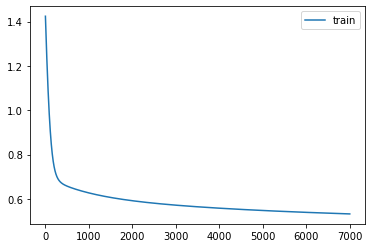

In [644]:
weights = neural_network(train_x, train_y, [train_x.shape[1],5,1], 7000, 0.01, 0)

In [642]:
pred_y = prediction(train_x, weights, 0.5)
result = (pred_y == train_y).astype(int)
print(result.sum() / result.shape[1])

[[0.38666535 0.49332747 0.37475218 0.54718299 0.38440701 0.39239298
  0.40117933 0.52162639 0.40325267 0.40383211 0.51687903 0.53039842
  0.51774049 0.52772848 0.39116684 0.51598988 0.39485251 0.46494108
  0.47574071 0.5143744  0.44639733 0.52955946 0.45307185 0.52081035
  0.49223567 0.48976558 0.38650495 0.50470851 0.43180485 0.50233457
  0.51862832 0.3713209  0.36835257 0.49080449 0.49003945 0.46888646
  0.49565421 0.44897963 0.52747419 0.49995206 0.49517847 0.43062533
  0.52547367 0.46091573 0.54460555 0.42500937 0.38073804 0.46338139
  0.36697047 0.37583071 0.38676524 0.38688267 0.52581903 0.52509042
  0.36623667 0.52454872 0.5169235  0.54715709 0.45071343 0.36557274
  0.44975735 0.37601599 0.48048092 0.42972304 0.4068888  0.48160741
  0.49612547 0.3711318  0.4658676  0.45720597 0.48394838 0.49739664
  0.47268125 0.38355833 0.36163838 0.39687864 0.43907631 0.41946689
  0.38753559 0.37543874 0.36528291 0.45508334 0.37672555 0.48578988
  0.47189532 0.50227892 0.43054745 0.51588659 0.

[array([[0.01233256, 0.97418941, 0.47393828, 0.13411085, 0.07915464,
        0.86393088, 0.04969164, 0.19779118, 0.55113012, 0.4921008 ,
        0.86180752, 0.81127757, 0.0462433 , 0.28245971, 0.31557382,
        0.5095119 , 0.22711222, 0.46446012, 0.33662844, 0.87194067,
        0.91264473],
       [0.31831142, 0.48316084, 0.12610075, 0.5442604 , 0.01541592,
        0.2035134 , 0.2784432 , 0.91534143, 0.64755745, 0.55089314,
        0.62339496, 0.11940831, 0.83923173, 0.63424563, 0.20628569,
        0.43844346, 0.29627072, 0.07384159, 0.3260199 , 0.48235973,
        0.92154796],
       [0.37128649, 0.64932639, 0.69148163, 0.61291651, 0.4878211 ,
        0.41181992, 0.56189584, 0.6278258 , 0.54913168, 0.07281355,
        0.15772979, 0.14176635, 0.72842587, 0.77976851, 0.18895066,
        0.5229134 , 0.21126812, 0.11840157, 0.53872869, 0.25337467,
        0.92229296],
       [0.2411505 , 0.97868184, 0.52113577, 0.74249303, 0.09310113,
        0.8573556 , 0.93578042, 0.83892473, 0.413201

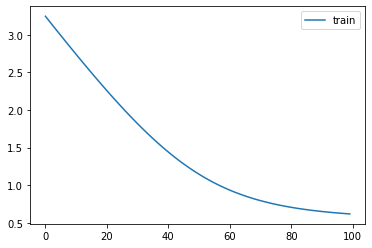

In [468]:
df = pd.read_csv("data/mobile_price_classification_train.csv")
train_x = df.loc[:, df.columns != "price_range"]
train_y = df["price_range"]
train_mean = train_x.mean(axis=0) # mean normalization
train_std = train_x.std(axis=0)
train_x = normalize(train_x,train_mean ,train_std).values
train_y = train_y.values
n_values = np.max(train_y) + 1
train_y = np.eye(n_values)[train_y]
train_y = train_y[:,0]
train_y = train_y.reshape(1,len(train_y))
train_y
# gradient_checking(train_x, train_y, [train_x.shape[1],2,2,1], 0.1)
weights = neural_network(train_x, train_y, [train_x.shape[1],10,10,1], 100, 0.01, 0)

In [610]:
np.random.seed(5)
X=np.random.normal(size=(5,4))
beta = np.random.normal(size=(4,))
y = X @ beta + np.random.normal(size=(5,))
print(y)
y = (y > 0).astype(int)
print("---X---")
print(X)
print("---beta---")
print(beta)
print("---y---")
print(y)

[-1.16555207  0.29169504  1.28433774  1.21879873 -1.67212138]
---X---
[[ 0.44122749 -0.33087015  2.43077119 -0.25209213]
 [ 0.10960984  1.58248112 -0.9092324  -0.59163666]
 [ 0.18760323 -0.32986996 -1.19276461 -0.20487651]
 [-0.35882895  0.6034716  -1.66478853 -0.70017904]
 [ 1.15139101  1.85733101 -1.51117956  0.64484751]]
---beta---
[-0.98060789 -0.85685315 -0.87187918 -0.42250793]
---y---
[0 1 1 1 0]


[array([[0.63979518, 0.9856244 , 0.2590976 , 0.80249689, 0.87048309],
       [0.92274961, 0.00221421, 0.46948837, 0.98146874, 0.3989448 ],
       [0.81373248, 0.5464565 , 0.77085409, 0.48493107, 0.02911156],
       [0.08652569, 0.11145381, 0.25124511, 0.96491529, 0.63176605]]), array([[0.8166602 , 0.566082  , 0.63535621, 0.81190239, 0.92668262]])]


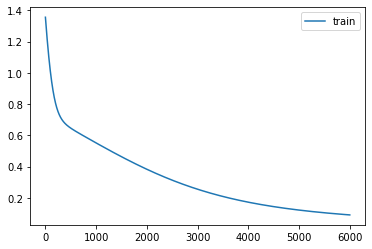

In [611]:
weights = neural_network(X, y, [X.shape[1],4,1], 6000, 0.01, 0)

In [612]:
pred_y = prediction(X, weights)

[[0.03261223 0.8735668  0.9176734  0.95787474 0.14310668]]


In [613]:
weights

[array([[-0.13689012,  1.91544657,  0.52150763,  1.5408821 ,  2.27284891],
        [ 0.4825117 ,  0.58121609,  0.63342488,  1.35539022,  1.23929718],
        [ 1.05722863,  0.34175966,  0.8307323 , -0.5317151 , -0.22999429],
        [-0.05044357,  0.55645923,  0.50364031,  1.04191289,  1.1751702 ]]),
 array([[ 2.24292033, -3.60128601, -1.4664374 ,  1.22516442, -1.3409284 ]])]